<a href="https://colab.research.google.com/github/deepsharma26/SIRT1_ML_NPASS/blob/main/Part9_Unknown_dataset_predictions_using_QDA%2BROS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediction of unknown dataset (NPASS-30846 compounds)

Rebuilding the previous model (QDA + ROS) for loading into pickle module

Original dataset shape: Counter({0: 803, 1: 155})

Resampled shape (ROSE-style): Counter({1: 803, 0: 803})

Accuracy: 0.8195020746887967
Balanced Accuracy: 0.8195020746887967
F1 Score: 0.8087912087912088
Cohen's Kappa: 0.6390041493775933
Mean Absolute Error: 0.18049792531120332

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       241
           1       0.86      0.76      0.81       241

    accuracy                           0.82       482
   macro avg       0.82      0.82      0.82       482
weighted avg       0.82      0.82      0.82       482


Confusion Matrix:
 [[211  30]
 [ 57 184]]


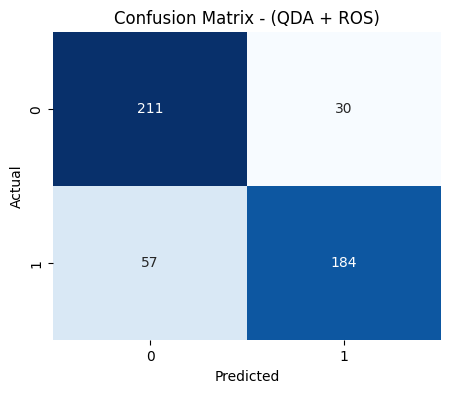

ROC AUC: 0.909135517639159


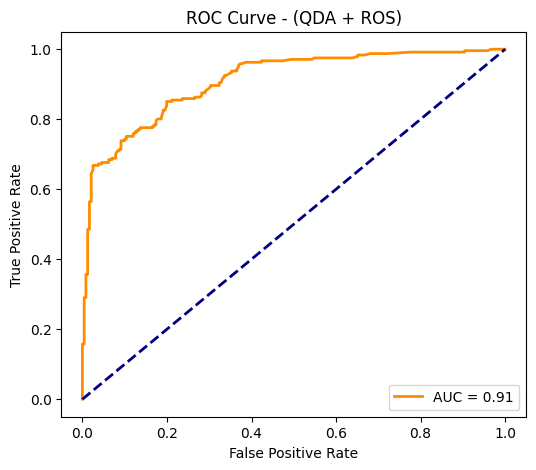

Stratified 10-Fold CV Accuracies: [0.77876106 0.82300885 0.76106195 0.79646018 0.84821429 0.86607143
 0.82142857 0.80357143 0.80357143 0.8125    ]
Mean Accuracy = 0.8115 ± 0.0292


In [ ]:
#3(a) QDA + ROS

!pip install imbalanced-learn scikit-learn numpy pandas matplotlib seaborn

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score,
    mean_absolute_error, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/Final_Trainset_Top20.csv")
X = df.drop("BioactivityClass", axis=1)
y = df["BioactivityClass"]

print("Original dataset shape:", Counter(y))

ros = RandomOverSampler(shrinkage=0.1, random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

print("\nResampled shape (ROSE-style):", Counter(y_ros))

# Now perform the train-test split on the resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_ros, y_ros, test_size=0.3, random_state=42, stratify=y_ros
)

#saving the train and test set
#Save Train set BEFORE ROS sampling (using original X, y before ROS)
train_before = pd.concat([X.reset_index(drop=True),
                          pd.Series(y, name="BioactivityClass")], axis=1)
train_before.to_csv("Trainset_Before_QDA_ROS.csv", index=False)

#Save Train set AFTER ROS sampling (using X_train, y_train from the split of resampled data)
train_after = pd.concat([X_train.reset_index(drop=True),
                         pd.Series(y_train, name="BioactivityClass")], axis=1)
train_after.to_csv("Trainset_After_QDA_ROS.csv", index=False)

#Save Test set (using X_test, y_test from the split of resampled data)
test_set = pd.concat([X_test.reset_index(drop=True),
                      pd.Series(y_test, name="BioactivityClass")], axis=1)
test_set.to_csv("QDA_ROS_Testset.csv", index=False)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)


y_pred = qda.predict(X_test_scaled)
y_proba = qda.predict_proba(X_test_scaled)[:, 1] if len(qda.classes_) == 2 else None


print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - (QDA + ROS)")
plt.savefig("Confusion_matrix_QDA_ROS_sampling.jpg", dpi=300, bbox_inches = 'tight')
plt.show()



if y_proba is not None:
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC:", roc_auc)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - (QDA + ROS)")
    plt.legend(loc="lower right")
    plt.savefig("ROC_QDA_ROS.jpg", dpi=300, bbox_inches = 'tight')
    plt.show()


##Validation using StratifiedKFold for QDA + ROS
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation using QDA + ROS
cv_scores = cross_val_score(
    QuadraticDiscriminantAnalysis(),
    X_train, y_train,  # Use X_train, y_train from the split of resampled data
    cv=skf, scoring='accuracy'
)

print("Stratified 10-Fold CV Accuracies:", cv_scores)
print(f"Mean Accuracy = {np.mean(cv_scores):.4f} \u00b1 {np.std(cv_scores):.4f}")


##Saving model
import pickle

# Save trained model
with open("QDA_ROS_model.pkl", "wb") as file:
    pickle.dump(qda, file)


Loading the buid model

In [ ]:
import pickle

# Save model
with open("QDA_ROS_model.pkl", "wb") as model_file:
    pickle.dump(qda, model_file)

# Load model
with open("QDA_ROS_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

# Test loaded model
y_pred_loaded = loaded_model.predict(X_test_scaled)
print(f"Loaded Model Accuracy: {accuracy_score(y_test, y_pred_loaded)}")

Loaded Model Accuracy: 0.8195020746887967


Loading unkown dataset and screening using QDA + ROS

In [ ]:
import pandas as pd

# Load unknown data
unknown_df = pd.read_csv("Unknowns_IN_AD_30846.csv")

In [ ]:
# Get the feature names used during training
training_features = X.columns

# Select only the necessary columns from unknown_df, and reorder them
unknown_df = unknown_df.reindex(columns=training_features)


In [ ]:
# Fill any potential NaN values with 0 (or another appropriate imputation strategy)
unknown_df = unknown_df.fillna(0)

# Scale the unknown data using the same scaler fitted on the training data
unknown_df_scaled = scaler.transform(unknown_df)

# Predict class labels
predictions = loaded_model.predict(unknown_df_scaled)

# Predict probabilities (if needed)
probabilities = loaded_model.predict_proba(unknown_df_scaled)

original_unknown_df = pd.read_csv("Unknowns_IN_AD_30846.csv")
SMILES = original_unknown_df["SMILES"]

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame({
    "SMILES": SMILES,
    "Predicted_Class": predictions,
    "Probability_Class_0": probabilities[:, 0],  # Probability of class 0
    "Probability_Class_1": probabilities[:, 1]   # Probability of class 1
})

# Save predictions
predictions_df.to_csv("Unknown_predictions_QDA+ROS.csv", index=False)
print("Predictions saved to Unknown_predictions_QDA+ROS.csv")


Predictions saved to Unknown_predictions_QDA+ROS.csv


#Similarly other model (XGBClassifier +ROS) was also used to predcit the unknown dataset as active or inactive compounds